In [85]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords

In [89]:
import json

with open('small.omtm.usa.json') as infile:
    tweet_json = json.load(infile)

tweet_dict = {}

#initialize columns
for k in tweet_json[0].keys():
    tweet_dict[k] = []

#fill columns
for l in tweet_json:
    for tup in l.items():
        tweet_dict[tup[0]].append(tup[1])

In [90]:
#Convert to DF
tweet_df = pd.DataFrame(tweet_dict)

#Load in the dataframe of word-happiness rankings
sent_df = pd.DataFrame.from_csv('Data_Set_S1.txt', sep='\t', index_col=None)

#Load in stopwords
cachedStopWords = stopwords.words("english")

Let's prepare some regular expressions to handle abbreviations that people sometimes extend for emphasis like 'lollllll' or 'lmaoooo' or 'hahaha'. (Haven't finished this yet).

In [91]:
import re

#lollll -> lol. lmaoooooo -> lmao.
emph_stem = lambda s: re.sub(r'((\w)\2{2,})','\\2', s)

#this has it's own happiness rating
lolol = lambda s: re.sub(r'lolol(ol)*', 'lolol', s)

#(all three of these appear separately in the word positivity list)
haha = lambda s: re.sub(r'[a|h]{3,4}','haha', s)
hahaha = lambda s: re.sub(r'[a|h]{5,6}','hahaha', s)
hahahaha = lambda s: re.sub(r'[a|h]{7,140}','hahahaha', s)

def apply_re(word):
    if lolol(word) != word:
        return lolol(word)
    elif haha(word) != word:
        return haha(word)
    elif hahaha(word) != word:
        return hahaha(word)
    elif hahahaha(word) != word:
        return hahahaha(word)
    elif emph_stem(word) != word:
        return emph_stem(word)
    return word

#Let's create some functions to get simple happiness metrics for each tweet.

Here's one that takes in raw tweet text, removes stopwords and punctuation (this includes emoticons, but maybe it shouldn't), and returns the tweet as a list of words.

In [92]:
def tweet_to_list(tweet):
    
    tweet_list = nltk.tokenize.word_tokenize(tweet)
    tweet_list = [word.lower() for word in tweet_list if word.isalpha()]
    
    cachedStopWords.append('https')
    tweet_list = [word for word in tweet_list if word not in cachedStopWords]
    tweet_list = [apply_re(word) for word in tweet_list]
    
    return tweet_list

The function avg_happiness takes in the list of words in a tweet, obtains the frequency distribution of each word, then calculates a weighted average "happiness" score based on each word's happiness rating (from Data_Set_S1).

In [93]:
def avg_happiness(text_list):
    freqdist = nltk.FreqDist(text_list).items()
    
    happ_sum = 0
    count = 0
    
    for i in freqdist:
        word_row = sent_df[sent_df.word == i[0]]
        happ_score = word_row.happiness_average.values
        for i in happ_score:
            happ_sum += int(i)
            count += 1
            
    if count == 0:
        return None
    
    happ_frac float(happ_sum)/count

Now create a new row in tweet_df with happiness scores for each tweet. Note that with only around 35,000 tweets, the following takes ~30 minutes to run. This means that we probably shouldn't use all of the million+ tweets we're collecting — rather, we should probably try to sample a reasonable, equal number of tweets from each state in the hopes of obtaining balanced representation (i.e., excluding some tweets from the more twitter-heavy states once we have enough overall).

In [94]:
%time

happiness_score = lambda tweet: avg_happiness(tweet_to_list(tweet))
tweet_df['happ_scores'] = pd.Series(tweet_df.ttext_cleand.apply(happiness_score))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [95]:
#remove tweets with NaN happiness scores
tweet_df.dropna(inplace=True)

In [124]:
state_avg_happ = {}

for state in tweet_df.state.unique():
    try:
        int(state)
    except:
        if len(state) != 2:
            continue
        state_col = tweet_df[tweet_df.state==state].happ_scores
        state_avg = np.mean(state_col)
        state_avg_happ[state] = np.mean(state_avg)

{u'AK': 5.0938856657436604,
 u'AL': 5.1728599859795743,
 u'AR': 5.2347587562214697,
 u'AZ': 5.2160080705986402,
 u'C1': 4.5454545454545459,
 u'CA': 5.1992505248993783,
 u'CO': 5.2314900550998811,
 u'CT': 5.1540412866353549,
 u'Co': 5.6432539682539691,
 u'DC': 5.127942234828196,
 u'DE': 5.1186952053548698,
 u'FL': 5.1597567998251721,
 u'Fu': 5.25,
 u'GA': 5.1303587866083573,
 u'HI': 5.1925207662707695,
 u'HQ': 5.1791666666666663,
 u'IA': 5.1014636022308677,
 u'ID': 5.2557282747994227,
 u'IL': 5.1768152940533918,
 u'IN': 5.2066100054664837,
 u'KS': 5.2482477112672745,
 u'KY': 5.1746986283918091,
 u'LA': 5.0608009396292468,
 u'MA': 5.2085517623416981,
 u'MD': 5.1125937043422889,
 u'ME': 5.2307656781557865,
 u'MI': 5.1556551296283493,
 u'MN': 5.2259068435506091,
 u'MO': 5.191238221582112,
 u'MS': 5.1906060178389435,
 u'MT': 5.2803171627913894,
 u'NC': 5.1808012483163202,
 u'ND': 5.2836547824352689,
 u'NE': 5.2192696941506451,
 u'NH': 5.1849224674696357,
 u'NJ': 5.1602668448331652,
 u'NM': 

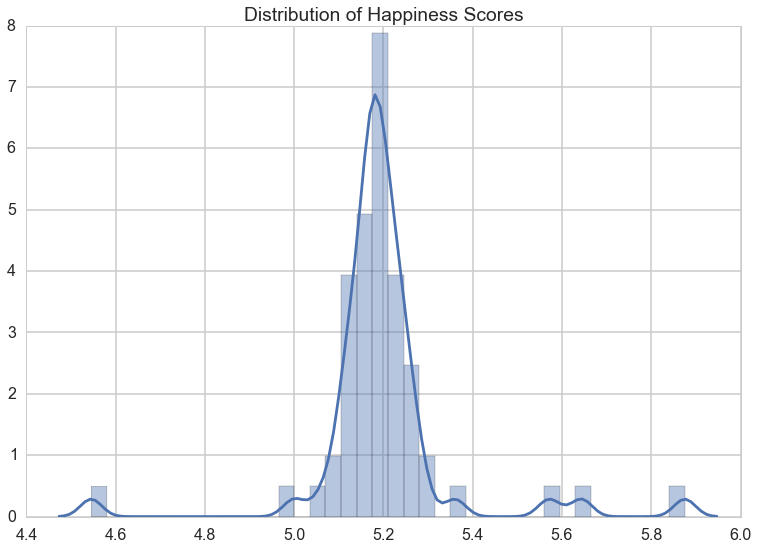

In [126]:
ax = sns.distplot(state_avg_happ.values())
ax.set_title('Distribution of Happiness Scores')

In [144]:
def norm(col):
    return (col - np.mean(col))/(max(col) - min(col))

tweet_df.norm_happ = norm(tweet_df.happ_scores)

#add boolean tweet positivity indicator
tweet_df['bool_happ'] = pd.Series(tweet_df.norm_happ > 0)

print 'Ratio positive tweets in New York: ' + str(np.mean(tweet_df[tweet_df.state=='NY'].bool_happ))
print 'Ratio positive tweets in Louisiana: ' + str(np.mean(tweet_df[tweet_df.state=='LA'].bool_happ))

Ratio positive tweets in New York: 0.472920085848
Ratio positive tweets in Louisiana: 0.386697602475


In [145]:
tweet_df.to_csv('tweets_w_sent.csv', encoding='utf-8')

In [147]:
tweet_df.head(50)

,coords,country,lang,place,state,timestamp,ttext,ttext_cleand,tweetid,userid,happ_scores,bool_happ
0,"47.614937999999995,-122.3306025",United States,en,"Seattle, WA",WA,1447266708839,"After taking public transit in DC and Seattle,...","after taking public transit in dc and seattle,...",664510856407834624,537328079,5.222222,True
1,"37.7050435,-122.162294",United States,en,"San Leandro, CA",CA,1447266710015,"Thankful for all the veterans out there, I lov...","thankful for all the veterans out there, i lov...",664510861340340228,3896359752,6.666667,True
2,"37.7706565,-122.4359785",United States,en,"San Francisco, CA",CA,1447266716814,"@Priz I've been watching, but not really enjoy...","AT_USER i've been watching, but not really enj...",664510889857433600,15532647,5.714286,True
3,"26.270260999999998,-80.2497725",United States,en,"Coral Springs, FL",FL,1447266717060,@awolnation it's my bday too 💕,AT_USER it's my bday too 💕,664510890889342976,1064780006,7.000000,True
4,"39.7795625,-86.1429225",United States,en,"Indianapolis, IN",IN,1447266716818,@bobandtom VIP cam has been running over 7 hou...,AT_USER vip cam has been running over 7 hours!...,664510889874186240,63448519,5.200000,True
5,"30.476215500000002,-84.266174",United States,en,"Tallahassee, FL",FL,1447266717136,@KarenKeyLargo @Jimbro_Fisher @ebosshoops Miam...,AT_USER AT_USER AT_USER miami is in the acc to...,664510891208155136,412603689,6.000000,True
7,"41.013875,-74.12256500000001",United States,en,"Waldwick, NJ",NJ,1447266713772,Congrats morgy so proud!!!! love you frick 🤗❤...,congrats morgy so proud!!!! love you frick 🤗❤...,664510877098446848,471233434,7.333333,True
8,"35.2112555,-101.816092",United States,en,"Amarillo, TX",TX,1447266713987,@KolKhaos Lol. Rarely that happens for me. I'm...,AT_USER lol. rarely that happens for me. i'm a...,664510878000136192,99543075,5.142857,False
9,"30.323345500000002,-97.754724",United States,en,"Austin, TX",TX,1447266713924,"On this Veterans Day &amp; every day, we thank...","on this veterans day &amp; every day, we thank...",664510877735882752,188104414,5.545455,True
11,"29.721989,-95.7787115",United States,en,"Cinco Ranch, TX",TX,1447266722856,You are something else i swear.. 🙄🙄🙄😒,you are something else i swear.. 🙄🙄🙄😒,664510915199369216,467926135,4.500000,False
